In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn
import torch.optim as optim 

import itertools

from copy import deepcopy

import optimization_lib as optim_lib
import rao_blackwellization_lib as rb_lib
import baselines_lib as bs_lib 

from toy_experiment_lib import ToyExperiment

In [2]:
np.random.seed(454)
_ = torch.manual_seed(454)

# Fixed parameters

In [3]:
k = 5
p0 = torch.rand(k)

In [4]:
eta = torch.Tensor([5.])
toy_experiment = ToyExperiment(eta, p0)

# Get true gradient 

In [5]:
toy_experiment.set_parameter(eta)
full_loss = toy_experiment.get_full_loss()

In [6]:
full_loss.backward()

In [7]:
true_grad = toy_experiment.eta.grad

In [8]:
true_grad

tensor([ 2.3195])

# Integrate out REINFORCE analytically, check gradient 

In [9]:
toy_experiment.set_parameter(eta)
pm_loss = toy_experiment.get_pm_loss(topk = k, grad_estimator = bs_lib.reinforce)

In [10]:
pm_loss

tensor(-3.1894)

In [11]:
pm_loss.backward()

In [12]:
toy_experiment.eta.grad

tensor([ 2.3195])

In [13]:
# why isn't this zero?
np.abs(true_grad - toy_experiment.eta.grad)

tensor(1.00000e-07 *
       [ 2.3842])

In [14]:
def assert_close(x, y, tol): 
    diff = np.abs(x - y)
    assert diff < tol, 'difference = {}, tolerance = {}'.format(diff, tol)

In [15]:
assert_close(true_grad, toy_experiment.eta.grad, tol = 1e-6)

# Sample and check REINFORCE 

In [16]:
n_samples = 10000

reinforce_grads = torch.zeros(n_samples)
reinforce_pm_losses = torch.zeros(n_samples)

for i in range(n_samples): 
    toy_experiment.set_parameter(eta)
    pm_loss = toy_experiment.get_pm_loss(topk = 0, grad_estimator = bs_lib.reinforce)
    reinforce_pm_losses[i] = pm_loss
    pm_loss.backward()
    
    reinforce_grads[i] = toy_experiment.eta.grad

In [17]:
torch.mean(reinforce_grads)

tensor(2.3422)

In [18]:
torch.std(reinforce_grads) / np.sqrt(n_samples)

tensor(1.00000e-02 *
       1.3096)

In [19]:
assert_close(torch.mean(reinforce_grads), 
             true_grad, 
             3 * torch.std(reinforce_grads) / np.sqrt(n_samples))

In [20]:
torch.mean(reinforce_pm_losses)

tensor(-2.9404)

In [21]:
torch.std(reinforce_pm_losses)

tensor(11.2301)

(array([ 137.,    0.,    0.,  123.,    0.,    0.,    0.,    0.,  930.,
        8810.]), array([-78.96615601, -71.00912486, -63.05209371, -55.09506256,
        -47.13803141, -39.18100026, -31.22396911, -23.26693797,
        -15.30990682,  -7.35287567,   0.60415548]), <a list of 10 Patch objects>)

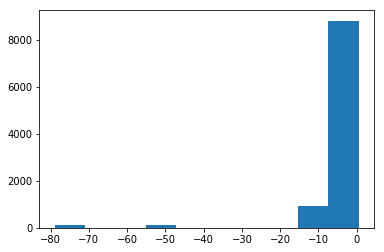

In [22]:
plt.hist(reinforce_pm_losses.detach())

(array([ 137.,    0.,    0.,  123.,    0.,    0.,    0.,    0., 6757.,
        2983.]),
 array([-6.10451317, -5.14670391, -4.18889465, -3.2310854 , -2.27327614,
        -1.31546688, -0.35765762,  0.60015163,  1.55796089,  2.51577015,
         3.47357941]),
 <a list of 10 Patch objects>)

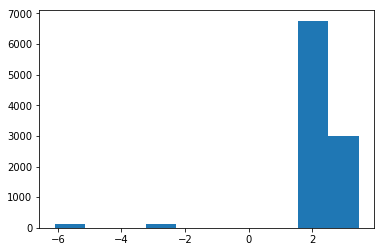

In [30]:
plt.hist(reinforce_grads.detach())

# Check REBAR

In [32]:
n_samples = 10000

rebar_grads = torch.zeros(n_samples)
rebar_pm_losses = torch.zeros(n_samples)
for i in range(n_samples): 
    toy_experiment.set_parameter(eta)
    pm_loss = toy_experiment.get_pm_loss(topk = 0, grad_estimator = bs_lib.rebar, 
                          grad_estimator_kwargs = {'temperature': 0.1, 'eta': 1.0})
    rebar_pm_losses[i] = pm_loss
    pm_loss.backward()
    
    rebar_grads[i] = toy_experiment.eta.grad


In [33]:
assert_close(true_grad, torch.mean(rebar_grads), 
             tol = 3 * torch.std(rebar_grads) / np.sqrt(n_samples))

In [34]:
torch.mean(rebar_grads)

tensor(2.3208)

In [35]:
torch.std(rebar_grads) / np.sqrt(n_samples)

tensor(1.00000e-02 *
       3.1641)

(array([1.000e+00, 5.000e+00, 3.000e+00, 1.000e+01, 1.500e+01, 6.734e+03,
        2.418e+03, 6.160e+02, 1.080e+02, 9.000e+01]),
 array([-31.14903641, -25.53413277, -19.91922913, -14.30432549,
         -8.68942184,  -3.0745182 ,   2.54038544,   8.15528908,
         13.77019272,  19.38509636,  25.        ]),
 <a list of 10 Patch objects>)

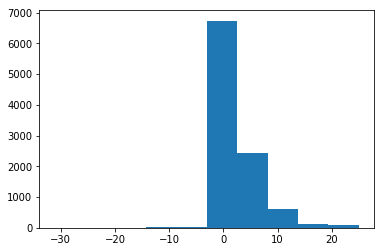

In [36]:
plt.hist(rebar_pm_losses.detach())

In [37]:
torch.mean(rebar_pm_losses)

tensor(2.5993)

In [38]:
torch.std(rebar_pm_losses)

tensor(3.4871)

(array([1.00e+01, 1.00e+01, 7.00e+00, 1.40e+01, 1.70e+01, 2.00e+01,
        3.10e+01, 2.15e+02, 8.73e+03, 9.46e+02]),
 array([-43.90163422, -38.51109724, -33.12056026, -27.73002329,
        -22.33948631, -16.94894934, -11.55841236,  -6.16787539,
         -0.77733841,   4.61319857,  10.00373554]),
 <a list of 10 Patch objects>)

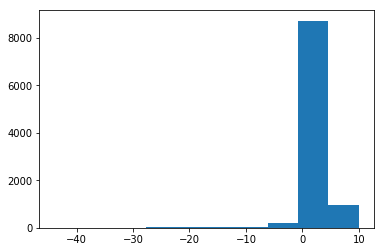

In [39]:
plt.hist(rebar_grads.detach())

# Check REINFORCE with simple baseline 

In [20]:
n_samples = 10000

reinforce_cv_grads = torch.zeros(n_samples)

for i in range(n_samples): 
    toy_experiment.set_parameter(eta)
    pm_loss = toy_experiment.get_pm_loss(topk = 0, grad_estimator = bs_lib.reinforce_w_double_sample_baseline)
    pm_loss.backward()
    
    reinforce_cv_grads[i] = toy_experiment.eta.grad

In [21]:
torch.mean(reinforce_cv_grads)

tensor(2.3381)

In [22]:
torch.std(reinforce_cv_grads) / np.sqrt(n_samples)

tensor(1.00000e-02 *
       1.5150)

In [23]:
assert_close(torch.mean(reinforce_cv_grads), 
             true_grad, 
             3 * torch.std(reinforce_cv_grads) / np.sqrt(n_samples))

# Check Rao-blackwellization of simple baseline

In [24]:
n_samples = 10000

reinforce_rb_grads = torch.zeros(n_samples)

for i in range(n_samples): 
    toy_experiment.set_parameter(eta)
    pm_loss = toy_experiment.get_pm_loss(topk = 3, grad_estimator = bs_lib.reinforce_w_double_sample_baseline)
    pm_loss.backward()
    
    reinforce_rb_grads[i] = toy_experiment.eta.grad

In [25]:
torch.mean(reinforce_rb_grads)

tensor(2.3183)

In [26]:
torch.std(reinforce_rb_grads) / np.sqrt(n_samples)

tensor(1.00000e-03 *
       3.4145)

In [27]:
assert_close(torch.mean(reinforce_rb_grads), 
             true_grad, 
             3 * torch.std(reinforce_rb_grads) / np.sqrt(n_samples))

# Check REBAR

In [28]:
n_samples = 10000

rebar_grads = torch.zeros(n_samples)

for i in range(n_samples): 
    toy_experiment.set_parameter(eta)
    pm_loss = toy_experiment.get_pm_loss(topk = 0, grad_estimator = bs_lib.rebar, 
                          grad_estimator_kwargs = {'temperature': 0.1, 'eta': 1.})
    pm_loss.backward()
    
    rebar_grads[i] = toy_experiment.eta.grad

In [29]:
assert_close(true_grad, torch.mean(rebar_grads), 
             tol = 3 * torch.std(rebar_grads) / np.sqrt(n_samples))

In [43]:
torch.mean(rebar_grads)

tensor(2.3386)

In [42]:
 3 * torch.std(rebar_grads) / np.sqrt(n_samples)

tensor(1.00000e-02 *
       8.9940)

# Check gumbel 

In [30]:
n_samples = 10000

gumbel_grads = torch.zeros(n_samples)

for i in range(n_samples): 
    toy_experiment.set_parameter(eta)
    pm_loss = toy_experiment.get_pm_loss(topk = 0, grad_estimator = bs_lib.gumbel, 
                          grad_estimator_kwargs = {'annealing_fun': lambda x : 0.01})
    pm_loss.backward()
    
    gumbel_grads[i] = toy_experiment.eta.grad

In [31]:
torch.mean(gumbel_grads)

tensor(2.2145)

In [32]:
3 * torch.std(gumbel_grads) / np.sqrt(n_samples)

tensor(0.4803)

In [33]:
# Check NVIL 

In [39]:
n_samples = 10000

nvil_grads = torch.zeros(n_samples)

baseline_nn = bs_lib.BaselineNN(slen = 5)

for i in range(n_samples): 
    toy_experiment.set_parameter(eta)
    pm_loss = toy_experiment.get_pm_loss(topk = 0, grad_estimator = bs_lib.nvil, 
                          grad_estimator_kwargs = {'baseline_nn': baseline_nn})
    pm_loss.backward()
    
    nvil_grads[i] = toy_experiment.eta.grad

In [40]:
assert_close(true_grad, torch.mean(nvil_grads), 
             tol = 3 * torch.std(nvil_grads) / np.sqrt(n_samples))

In [41]:
3 * torch.std(nvil_grads) / np.sqrt(n_samples)

tensor(1.00000e-02 *
       4.1610)